In [133]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)
from pymc import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

## Speed
Our response will be predicted get off time
    - Need to decide how we want to do this
    - Option 1 is amount of time to get to a certain distance (Say 1.5 yards)
    - Option 2 would be predicted yards given a cetain amount of time
For predictors:
    - Height/weight of the tackle
    - Quarter
    - Whether it's an obvious passing situation
    - Left vs right tackle?

## Power
Our response here is some variation of percentage of the distance to the QB given up once engaged with the defensive end
For predictors:
    - Height/weight of both the tackle and the end
    - Obvious passing situation
    - Time to throw for the QB
    - Quarter

In [3]:
model_data = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/clustered.csv')

In [5]:
model_data.columns

Index(['uniqueplayId', 'QB_Flip', 'rushType', 'Power_prob', 'Speed_prob',
       'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'playDirection', 'event', 'ball_snap_frame', 'end_frame',
       'play_length_frames', 'Right_end', 'Left_end', 'QB_nflId',
       'QB_jerseyNumber', 'QB_team', 'QB_x', 'QB_y', 'QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp',
       'QB_pff_nflIdBlockedPlayer', 'QB_pff_blockType', 'QB_new_x', 'QB_new_y',
       'ball_nflId', 'ball_jerseyNumber', 'ball_team', 'ball_x', 'ball_y',
       'ball_s', 'ball_a', 'ball_dis', 'ball_o', 'ball_dir', 'ball_pff_role',
       'ball_pff_positionLinedUp', 'ball_pff_nflIdBlockedPlayer',
       'ball_pff_blockType', 'ball_new_x', 'ball_new_y', 'ball_Flip',
       'Tackle_nflId', 'Tackle_jerseyNumber', 'Tackle_team', 'Tackle_x',
       'Tackle_y', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLined

In [6]:
model_data2 = model_data[['uniqueplayId','QB_Flip','rushType','Power_prob','Speed_prob',
            'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'event','play_length_frames','QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp','QB_new_x', 'QB_new_y',
            'ball_new_x', 'ball_new_y', 'ball_Flip','ball_snap_frame',
       'Tackle_nflId', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLinedUp',
       'Tackle_pff_nflIdBlockedPlayer', 'Tackle_pff_blockType', 'Tackle_new_x',
       'Tackle_new_y', 'Tackle_Flip', 'End_nflId', 'End_s', 'End_a', 'End_dis', 'End_o',
       'End_dir', 'End_pff_role', 'End_pff_positionLinedUp', 'End_new_x',
       'End_new_y', 'End_Flip', 'tackle_end_dist', 'tackle_end_facing']]

In [7]:
players = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/players.csv')

In [8]:
players = players[['height', 'weight', 'nflId','displayName']]

In [9]:
model_data3 = model_data2.merge(players, left_on = 'Tackle_nflId', right_on = 'nflId', how = 'left')

In [10]:
model_data4 = model_data3.rename(columns = {'height':'tackle_height','weight':'tackle_weight','displayName':'tackle_name'}).drop('nflId', axis = 1)

In [11]:
model_data5 = model_data4.merge(players, left_on = 'End_nflId', right_on = 'nflId', how = 'left')

In [12]:
model_data6 = model_data5.rename(columns = {'height':'end_height','weight':'end_weight','displayName':'end_name'}).drop('nflId', axis = 1)

In [13]:
plays = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [14]:
plays['obvious_pass'] = ((plays['down'] == 2) & (plays['yardsToGo'] > 10)) | ((plays['down'] == 3) & (plays['yardsToGo'] > 4)) | ((plays['down'] == 4) & (plays['yardsToGo'] > 2))

In [15]:
plays['obvious_pass'] = plays['obvious_pass'].astype(int)

In [16]:
plays = plays[['gameId','playId','quarter','obvious_pass']]

In [17]:
plays

,gameId,playId,quarter,obvious_pass
0,2021090900,97,1,0
1,2021090900,137,1,0
2,2021090900,187,1,0
3,2021090900,282,1,0
4,2021090900,349,1,1
...,...,...,...,...
8553,2021110100,4310,4,1
8554,2021110100,4363,4,0
8555,2021110100,4392,4,0
8556,2021110100,4411,4,1


In [18]:
model_data7 = model_data6.merge(plays, on = ['gameId','playId'], how = 'left')

In [19]:
model_data7['tackle_end_engaged'] = (model_data7['tackle_end_facing'] <= 40) & (model_data7['tackle_end_dist'] <= 1)

In [20]:
model_data7['tackle_end_engaged'] = model_data7['tackle_end_engaged'].astype(int)

In [21]:
model_data7['tackle_end_engaged'].value_counts()

0    201295
1     50412
Name: tackle_end_engaged, dtype: int64

In [22]:
def dist(x_1, y_1, x_2, y_2):
    return np.sqrt(np.sum([(x_1-x_2)**2, (y_1-y_2)**2], axis=0))

In [23]:
model_data7['tackle_qb_dist'] = dist(model_data7['Tackle_new_x'], model_data7['Tackle_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [24]:
model_data7['end_qb_dist'] = dist(model_data7['End_new_x'], model_data7['End_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [25]:
speed = model_data7[model_data7['rushType'] == 'Speed']
speed

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,tackle_weight,tackle_name,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist
0,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,6,...,338,Donovan Smith,6-5,255,Randy Gregory,1,0,0,4.589466,10.452009
1,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,7,...,338,Donovan Smith,6-5,255,Randy Gregory,1,0,0,4.590697,10.450000
2,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,8,...,338,Donovan Smith,6-5,255,Randy Gregory,1,0,0,4.592004,10.358002
3,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,9,...,338,Donovan Smith,6-5,255,Randy Gregory,1,0,0,4.572800,10.242095
4,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,10,...,338,Donovan Smith,6-5,255,Randy Gregory,1,0,0,4.552296,9.912906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251646,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,22,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,5.290539,6.823738
251647,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,23,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,5.213694,6.747985
251648,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,24,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,5.160475,6.711073
251649,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,25,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,5.075924,6.692952


In [26]:
power = model_data7[model_data7['rushType'] == 'Power']

In [27]:
subset = power[power['tackle_end_engaged'] == 1]

In [28]:
subset2 = subset.groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [29]:
distance_when_engaged = subset2[['uniqueplayId','QB_Flip','tackle_qb_dist']]
distance_when_engaged

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109120163,0.0,3.927467
1,202109120163,1.0,5.853136
2,202109120676,0.0,4.894865
3,202109120676,1.0,3.900820
4,202109120776,0.0,4.369760
...,...,...,...
5434,20211025003660,1.0,5.355978
5435,20211025003904,0.0,3.735305
5436,20211025003904,1.0,4.439279
5437,20211025003926,0.0,4.778002


In [30]:
end_distance = model_data7.groupby(['uniqueplayId','QB_Flip']).last().reset_index()

In [31]:
end_distance = end_distance[['uniqueplayId','QB_Flip','tackle_qb_dist']]
end_distance

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109090097,0.0,3.197890
1,202109090097,1.0,2.797803
2,202109120163,0.0,3.003265
3,202109120163,1.0,4.141618
4,202109120288,0.0,4.306948
...,...,...,...
9091,20211025003684,1.0,2.564995
9092,20211025003904,0.0,2.465218
9093,20211025003904,1.0,3.892364
9094,20211025003926,0.0,7.646829


In [32]:
end_distance = end_distance.rename(columns = {'tackle_qb_dist': 'ending_distance'})

In [33]:
distance = distance_when_engaged.merge(end_distance, on = ['uniqueplayId', 'QB_Flip'], how = 'left')
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance
0,202109120163,0.0,3.927467,3.003265
1,202109120163,1.0,5.853136,4.141618
2,202109120676,0.0,4.894865,4.512704
3,202109120676,1.0,3.900820,2.987072
4,202109120776,0.0,4.369760,3.070261
...,...,...,...,...
5434,20211025003660,1.0,5.355978,4.189141
5435,20211025003904,0.0,3.735305,2.465218
5436,20211025003904,1.0,4.439279,3.892364
5437,20211025003926,0.0,4.778002,7.646829


In [34]:
distance['pct_given_up'] = (distance['tackle_qb_dist'] - distance['ending_distance']) / distance['tackle_qb_dist']
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance,pct_given_up
0,202109120163,0.0,3.927467,3.003265,0.235318
1,202109120163,1.0,5.853136,4.141618,0.292410
2,202109120676,0.0,4.894865,4.512704,0.078074
3,202109120676,1.0,3.900820,2.987072,0.234245
4,202109120776,0.0,4.369760,3.070261,0.297385
...,...,...,...,...,...
5434,20211025003660,1.0,5.355978,4.189141,0.217857
5435,20211025003904,0.0,3.735305,2.465218,0.340022
5436,20211025003904,1.0,4.439279,3.892364,0.123199
5437,20211025003926,0.0,4.778002,7.646829,-0.600424


In [35]:
distance = distance.rename(columns = {'tackle_qb_dist' : 'starting_distance'})

In [36]:
model_data8 = model_data7.merge(distance, on = ['uniqueplayId','QB_Flip'], how = 'left')
model_data8

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,starting_distance,ending_distance,pct_given_up
0,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,6,...,255,Randy Gregory,1,0,0,4.589466,10.452009,NaN,NaN,NaN
1,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,7,...,255,Randy Gregory,1,0,0,4.590697,10.450000,NaN,NaN,NaN
2,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,8,...,255,Randy Gregory,1,0,0,4.592004,10.358002,NaN,NaN,NaN
3,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,9,...,255,Randy Gregory,1,0,0,4.572800,10.242095,NaN,NaN,NaN
4,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,10,...,255,Randy Gregory,1,0,0,4.552296,9.912906,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251702,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,20,...,315,Jordan Elliott,3,0,0,4.995968,6.031923,NaN,NaN,NaN
251703,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,21,...,315,Jordan Elliott,3,0,0,5.045909,6.051859,NaN,NaN,NaN
251704,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,22,...,315,Jordan Elliott,3,0,0,5.093447,6.079753,NaN,NaN,NaN
251705,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,23,...,315,Jordan Elliott,3,0,0,5.107886,6.099746,NaN,NaN,NaN


In [37]:
## Going to need to remove any power plays where this is an NA
model_data8 = model_data8.dropna(subset = ['pct_given_up'])

In [38]:
speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()

/var/folders/d9/lqnstgr57q38yp_l9kjdv69c0000gn/T/ipykernel_55422/3903018070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()


In [39]:
one_yard = speed[speed['dist_moved'] >= 1].groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [40]:
one_yard = one_yard[['uniqueplayId','QB_Flip','frameId','ball_snap_frame']]

In [41]:
one_yard['tackle_get_off_time'] = (one_yard['frameId'] - one_yard['ball_snap_frame'])*.1

In [42]:
get_off = one_yard[['uniqueplayId','QB_Flip','tackle_get_off_time']]

In [43]:
speed2 = speed.merge(get_off, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [44]:
speed2

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time
0,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,6,...,6-5,255,Randy Gregory,1,0,0,4.589466,10.452009,0.08,0.5
1,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,7,...,6-5,255,Randy Gregory,1,0,0,4.590697,10.450000,0.19,0.5
2,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,8,...,6-5,255,Randy Gregory,1,0,0,4.592004,10.358002,0.34,0.5
3,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,9,...,6-5,255,Randy Gregory,1,0,0,4.572800,10.242095,0.56,0.5
4,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,10,...,6-5,255,Randy Gregory,1,0,0,4.552296,9.912906,0.80,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64743,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,22,...,6-0,232,Nick Bolton,2,0,0,5.290539,6.823738,3.33,0.7
64744,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,23,...,6-0,232,Nick Bolton,2,0,0,5.213694,6.747985,3.64,0.7
64745,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,24,...,6-0,232,Nick Bolton,2,0,0,5.160475,6.711073,3.93,0.7
64746,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,25,...,6-0,232,Nick Bolton,2,0,0,5.075924,6.692952,4.22,0.7


In [45]:
## Now looking at yards traveled in the first second
one_sec = speed2[speed2['frameId'] == speed2['ball_snap_frame'] + 10]
one_sec = one_sec[['uniqueplayId','QB_Flip','dist_moved']].rename(columns = {'dist_moved':'one_sec_dist'})

In [46]:
speed3 = speed2.merge(one_sec, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [47]:
speed3

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time,one_sec_dist
0,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,6,...,255,Randy Gregory,1,0,0,4.589466,10.452009,0.08,0.5,2.51
1,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,7,...,255,Randy Gregory,1,0,0,4.590697,10.450000,0.19,0.5,2.51
2,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,8,...,255,Randy Gregory,1,0,0,4.592004,10.358002,0.34,0.5,2.51
3,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,9,...,255,Randy Gregory,1,0,0,4.572800,10.242095,0.56,0.5,2.51
4,202109090097,0.0,Speed,0.18422,0.81578,41.56,23.92,2021090900,97,10,...,255,Randy Gregory,1,0,0,4.552296,9.912906,0.80,0.5,2.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64865,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,22,...,232,Nick Bolton,2,0,0,5.290539,6.823738,3.33,0.7,1.93
64866,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,23,...,232,Nick Bolton,2,0,0,5.213694,6.747985,3.64,0.7,1.93
64867,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,24,...,232,Nick Bolton,2,0,0,5.160475,6.711073,3.93,0.7,1.93
64868,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,25,...,232,Nick Bolton,2,0,0,5.075924,6.692952,4.22,0.7,1.93


In [48]:
one_sec_dist_df = speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['one_sec_dist'].unique()[0]).reset_index().rename(columns={0:'one_sec_dist'})

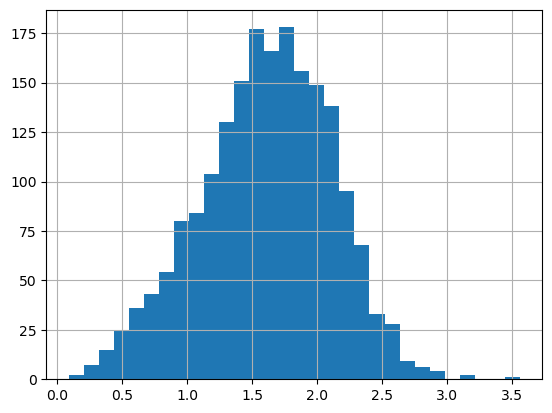

In [49]:
one_sec_dist_df['one_sec_dist'].hist(bins=30);

In [50]:
speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['end_name'].unique()[0]).reset_index().rename(columns={0:'end_name'})['end_name'].value_counts()[0:50]

Harold Landry          75
Derek Barnett          35
Myles Garrett          32
Yannick Ngakoue        29
Khalil Mack            29
Chase Young            28
Trey Hendrickson       27
Shaquil Barrett        26
Von Miller             23
Robert Quinn           22
Haason Reddick         22
Joey Bosa              21
T.J. Watt              21
Al-Quadin Muhammad     20
Darrell Taylor         20
Maxx Crosby            20
Nick Bosa              19
Rashan Gary            19
Montez Sweat           19
Brian Burns            18
Terrell Lewis          17
Malik Reed             17
Michael Danna          17
Josh Allen             17
Josh Sweat             16
Cameron Jordan         16
Bryce Huff             15
Justin Houston         15
Alex Highsmith         15
Olasunkanmi Adeniyi    15
Brandon Graham         15
Danielle Hunter        15
Matt Judon             14
Emmanuel Ogbah         14
Dante Fowler           14
Frank Clark            14
Jason Pierre-Paul      14
Dee Ford               13
Jacob Martin

In [51]:
speed3[speed3['end_name'] == 'Harold Landry']['uniqueplayId'].value_counts()

2021091912943     62
20210919124574    49
20210912071703    48
20211010043129    45
20211024052903    42
20210926083652    39
20211018002072    39
20211018001948    36
20211018001757    34
20211018003976    34
2021101800987     33
20210912072982    33
20211018003825    31
20211024052293    31
20210926082892    31
20211018002412    30
20210926081998    30
20211024053462    30
20211018001194    29
20210926082224    29
20211003074551    29
20211010041547    29
20210912071858    29
20211018003849    29
20211018002976    28
20211010043157    28
20211003072668    28
20211024053162    28
20210926082977    27
20211010043548    27
20211010043885    27
20211018002322    27
20211024052778    27
20211018003419    27
20210912072949    26
20211018001011    26
20211003071345    26
2021100307604     26
20211024052754    26
2021092608565     26
20211024053334    25
2021091207386     25
20211003073835    25
20210926082538    25
2021101800275     25
2021091912796     25
20210919124552    25
2021100307462

In [52]:
play = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [53]:
play['uniqueplayId'] = play['gameId'].astype(str) + play['playId'].astype(str)

In [54]:
play[play['uniqueplayId'].isin(['2021102405360','20211018002346','20210912071703','20211010043914','20211010043129'])]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,uniqueplayId
656,2021091207,1703,(6:50) (Shotgun) K.Murray pass incomplete deep...,2,1,10,ARI,TEN,ARI,25,...,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,20210912071703
4885,2021101004,3129,(12:21) (Shotgun) T.Lawrence pass deep left to...,4,1,10,JAX,TEN,JAX,30,...,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,1,Cover-2,Zone,20211010043129
4899,2021101004,3914,"(:31) (No Huddle, Shotgun) T.Lawrence pass sho...",4,3,1,JAX,TEN,JAX,48,...,62.0,EMPTY,"1 RB, 1 TE, 3 WR",4.0,"3 DL, 2 LB, 6 DB",TRADITIONAL,0,Cover-3,Zone,20211010043914
6574,2021101800,2346,"(12:41) (No Huddle, Shotgun) J.Allen pass shor...",3,1,10,BUF,TEN,BUF,44,...,66.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,20211018002346
7061,2021102405,360,(10:21) (Shotgun) P.Mahomes pass short right t...,1,2,5,KC,TEN,KC,30,...,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,2021102405360


In [55]:
power_speed_perc = model_data7.groupby(['end_name', 'uniqueplayId', 'QB_Flip']).agg({
    'rushType':'first'
}).reset_index().groupby('end_name')['rushType'].agg(
    power_perc = lambda x: x[x == 'Power'].count()/x.count(),
    speed_perc = lambda x: x[x == 'Speed'].count()/x.count(),
    total = 'count'
).reset_index()

In [56]:
overall_perc_avs = model_data7.groupby(['uniqueplayId', 'QB_Flip']).agg({
    'rushType':'first'
}).reset_index()['rushType'].value_counts(normalize=True)
overall_perc_avs

Power    0.786609
Speed    0.213391
Name: rushType, dtype: float64

In [57]:
power_speed_perc['Av_Power'] = overall_perc_avs[0]
power_speed_perc['Av_Speed'] = overall_perc_avs[1]
power_speed_perc['num_plays'] = power_speed_perc['total'].sum()
power_speed_perc['end_power_perc'] = power_speed_perc['power_perc']*(power_speed_perc['total']/500) + power_speed_perc['Av_Power']*(1-power_speed_perc['total']/500)
power_speed_perc['end_speed_perc'] = power_speed_perc['speed_perc']*(power_speed_perc['total']/500) + power_speed_perc['Av_Speed']*(1-power_speed_perc['total']/500)

In [58]:
power = model_data8.merge(power_speed_perc[['end_name', 'end_power_perc', 'end_speed_perc']], how='left', on='end_name')

In [59]:
speed3 = speed3.merge(power_speed_perc[['end_name', 'end_power_perc', 'end_speed_perc']], how='left', on='end_name')

In [60]:
# Aggregate for grouped by to prepare data for modeling - one row per tackle/end instance
# The row should have the distance of the tackle in one second, and multiple predictors
# The predictors are speed/power percent of the end, weight and height of end, one-hot offensive linesman, obvious passing situation, and maybe quarter
def full_agg(grouped_df):
    row = grouped_df[grouped_df['frameId']==grouped_df['ball_snap_frame']+10]
    return pd.DataFrame({
    'one_sec_dist': row['dist_moved'],
    'end_power_perc': row['end_power_perc'],
    'end_speed_perc':  row['end_speed_perc'],
    'end_height': row['end_height'],
    'end_weight': row['end_weight'],
    'tackle_name': row['tackle_name'],
    'obvious_pass': row['obvious_pass'],
    'quarter': row['quarter']
})

speed_data = speed3.groupby(['uniqueplayId', 'QB_Flip'], group_keys=True).apply(full_agg).reset_index().drop(['level_2'], axis=1)
speed_data

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter
0,202109090097,0.0,2.51,0.786216,0.213784,6-5,255,Donovan Smith,0,1
1,202109090097,1.0,1.46,0.784827,0.215173,6-3,245,Tristan Wirfs,0,1
2,202109120288,0.0,1.36,0.777999,0.222001,6-3,275,Mekhi Becton,0,1
3,202109120578,0.0,0.76,0.785472,0.214528,6-5,262,Laremy Tunsil,0,1
4,202109190555,1.0,1.15,0.784743,0.215257,6-2,318,Jesse Davis,0,1
...,...,...,...,...,...,...,...,...,...,...
1942,20211025003484,0.0,2.05,0.789572,0.210428,5-11,310,Terron Armstead,0,4
1943,20211025003506,0.0,0.87,0.784082,0.215918,6-4,279,Terron Armstead,1,4
1944,20211025003536,1.0,1.98,0.792718,0.207282,6-4,330,Ryan Ramczyk,0,4
1945,20211025003660,0.0,1.95,0.787011,0.212989,6-4,260,Terron Armstead,1,4


In [61]:
speed_data['end_height'] = [int(j)*12+int(i) for j, i in speed_data['end_height'].str.split('-')]

In [62]:
speed_data

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter
0,202109090097,0.0,2.51,0.786216,0.213784,77,255,Donovan Smith,0,1
1,202109090097,1.0,1.46,0.784827,0.215173,75,245,Tristan Wirfs,0,1
2,202109120288,0.0,1.36,0.777999,0.222001,75,275,Mekhi Becton,0,1
3,202109120578,0.0,0.76,0.785472,0.214528,77,262,Laremy Tunsil,0,1
4,202109190555,1.0,1.15,0.784743,0.215257,74,318,Jesse Davis,0,1
...,...,...,...,...,...,...,...,...,...,...
1942,20211025003484,0.0,2.05,0.789572,0.210428,71,310,Terron Armstead,0,4
1943,20211025003506,0.0,0.87,0.784082,0.215918,76,279,Terron Armstead,1,4
1944,20211025003536,1.0,1.98,0.792718,0.207282,76,330,Ryan Ramczyk,0,4
1945,20211025003660,0.0,1.95,0.787011,0.212989,76,260,Terron Armstead,1,4


In [63]:
tackles = speed_data['tackle_name'].unique()
len(tackles)

110

In [64]:
## Do we want to leave the tackles in the train set who don't have enough snaps to get test data? A couple need to be removed for sure since they are tight ends so I set keep if we have 5 instances
def split_data(data, tackles):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for name in tackles:
        tackle = data[data['tackle_name'] == name]
        if len(tackle) > 4:
            if len(tackle) >= 25:
                x_train,x_test = train_test_split(tackle, test_size=0.2, random_state = 1029)
                train_x = pd.concat([train_x, x_train])
                test_x = pd.concat([test_x, x_test])
            else:
                train_x = pd.concat([train_x, tackle])
    return train_x, test_x

In [114]:
train_speed, test_speed = split_data(speed_data, tackles)

In [105]:
train_speed['tackle_name'].value_counts()

Orlando Brown           42
Donovan Smith           35
Dion Dawkins            33
Kaleb McGary            33
Penei Sewell            32
D.J. Humphries          31
Alejandro Villanueva    31
Taylor Moton            29
Morgan Moses            28
Nate Solder             27
Rashod Hill             26
George Fant             25
Dan Moore               25
Garett Bolles           25
Mike McGlinchey         24
Matt Nelson             24
Kolton Miller           24
Storm Norton            24
Riley Reiff             24
Cameron Erving          24
Jedrick Wills           24
Liam Eichenberg         24
David Quessenberry      24
Charles Leno            24
Tristan Wirfs           23
Rob Havenstein          23
Daryl Williams          22
Eric Fisher             22
Julien Davenport        22
Justin Herron           22
Ryan Ramczyk            22
Patrick Mekari          21
Jason Peters            21
Rashawn Slater          21
Cam Robinson            21
Jesse Davis             21
Andre Dillard           21
B

In [67]:
test_speed['tackle_name'].value_counts()

Orlando Brown           11
Donovan Smith            9
Kaleb McGary             9
Dion Dawkins             9
D.J. Humphries           8
Taylor Moton             8
Morgan Moses             8
Penei Sewell             8
Alejandro Villanueva     8
Nate Solder              7
Garett Bolles            7
Dan Moore                7
Cameron Erving           7
George Fant              7
Kolton Miller            7
Rashod Hill              7
Matt Nelson              6
Liam Eichenberg          6
Cam Robinson             6
Eric Fisher              6
David Quessenberry       6
Julien Davenport         6
Patrick Mekari           6
Mike McGlinchey          6
Tristan Wirfs            6
Jason Peters             6
Jake Matthews            5
Samuel Cosmi             5
Bobby Massie             5
Billy Turner             5
Taylor Lewan             5
Brian O'Neill            5
Name: tackle_name, dtype: int64

In [68]:
## Amount removed as is
len(speed_data) - len(train_speed) - len(test_speed)

34

In [69]:
# Aggregate for grouped by to prepare data for modeling - one row per tackle/end instance
# The row should have the perctage of the distance given up once engaged, and multiple predictors
# The predictors are speed/power percent of the end, weight and height of end, one-hot offensive linesman, obvious passing situation, starting distance, length of the play, and maybe quarter
def full_agg(grouped_df):
    row = grouped_df[grouped_df['frameId']==grouped_df['ball_snap_frame']]
    return pd.DataFrame({
    'end_power_perc': row['end_power_perc'],
    'end_speed_perc':  row['end_speed_perc'],
    'end_height': row['end_height'],
    'end_weight': row['end_weight'],
    'tackle_name': row['tackle_name'],
    'obvious_pass': row['obvious_pass'],
    'quarter': row['quarter'],
    'pct_given_up': row['pct_given_up'],
    'starting_distance': row['starting_distance'],
    'play_length': row['play_length_frames']
})

power_data = power.groupby(['uniqueplayId', 'QB_Flip'], group_keys=True).apply(full_agg).reset_index().drop(['level_2'], axis=1)
power_data

,uniqueplayId,QB_Flip,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter,pct_given_up,starting_distance,play_length
0,202109120163,0.0,0.784777,0.215223,6-4,242,Dion Dawkins,0,1,0.235318,3.927467,22.0
1,202109120163,1.0,0.771070,0.228930,6-4,252,Daryl Williams,0,1,0.292410,5.853136,22.0
2,202109120676,0.0,0.794961,0.205039,6-2,270,Julien Davenport,0,1,0.078074,4.894865,21.0
3,202109120676,1.0,0.795338,0.204662,6-6,285,Braden Smith,0,1,0.234245,3.900820,21.0
4,202109120776,0.0,0.782241,0.217759,6-5,288,Taylor Lewan,1,1,0.297385,4.369760,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5434,20211025003660,1.0,0.794961,0.205039,6-2,270,Ryan Ramczyk,1,4,0.217857,5.355978,27.0
5435,20211025003904,0.0,0.791011,0.208989,6-6,265,Duane Brown,0,4,0.340022,3.735305,26.0
5436,20211025003904,1.0,0.792166,0.207834,6-4,287,Brandon Shell,0,4,0.123199,4.439279,26.0
5437,20211025003926,0.0,0.791011,0.208989,6-6,265,Duane Brown,0,4,-0.600424,4.778002,38.0


In [70]:
tackles_power = power_data['tackle_name'].unique()
len(tackles)

110

In [71]:
train_power, test_power = split_data(power_data, tackles_power)

In [72]:
train_power['tackle_name'].value_counts()

Tristan Wirfs           112
Jake Matthews           103
Donovan Smith           103
Penei Sewell            100
Rashawn Slater           92
Matt Nelson              91
Taylor Moton             91
Jonah Williams           91
Isaiah Wynn              88
Kolton Miller            88
Riley Reiff              78
Garett Bolles            75
Charles Leno             74
Liam Eichenberg          72
Brian O'Neill            72
Bobby Massie             72
Alejandro Villanueva     70
Rob Havenstein           69
Andrew Whitworth         68
David Quessenberry       66
Tyron Smith              65
Dan Moore                64
Kaleb McGary             64
Cam Robinson             63
Jawaan Taylor            61
Nate Solder              60
Storm Norton             60
Justin Herron            59
Andrew Thomas            57
Dion Dawkins             56
George Fant              54
Duane Brown              54
Trent Williams           53
Orlando Brown            53
Mike McGlinchey          52
D.J. Humphries      

In [73]:
test_power['tackle_name'].value_counts()

Tristan Wirfs           28
Donovan Smith           26
Jake Matthews           26
Penei Sewell            25
Taylor Moton            23
Rashawn Slater          23
Matt Nelson             23
Jonah Williams          23
Kolton Miller           23
Isaiah Wynn             23
Riley Reiff             20
Garett Bolles           19
Bobby Massie            19
Brian O'Neill           19
Charles Leno            19
Liam Eichenberg         19
Andrew Whitworth        18
Alejandro Villanueva    18
Rob Havenstein          18
Tyron Smith             17
David Quessenberry      17
Dan Moore               16
Kaleb McGary            16
Cam Robinson            16
Jawaan Taylor           16
Justin Herron           15
Andrew Thomas           15
Nate Solder             15
Dion Dawkins            15
Storm Norton            15
Orlando Brown           14
Mike McGlinchey         14
Duane Brown             14
George Fant             14
Trent Williams          14
Alex Leatherwood        13
Cameron Erving          13
T

In [74]:
## Amount removed as is
len(power_data) - len(train_power) - len(test_power)

28

In [122]:
## Speed modeling
tackle_len = len(train_speed['tackle_name'].unique())

In [123]:
tackle_dummies = pd.DataFrame(train_speed['tackle_name'].unique()).reset_index().rename(columns = {0:'tackle_name','index':'dummy_tackle'})
train_speed2 = train_speed.merge(tackle_dummies, on = ['tackle_name'], how = 'left')

In [125]:
train_speed2 = train_speed2.drop(['tackle_name'], axis = 1)

In [126]:
train_speed2

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,obvious_pass,quarter,dummy_tackle
0,2021090900434,0.0,2.11,0.786216,0.213784,77,255,0,1,0
1,20211010071914,0.0,1.45,0.786852,0.213148,78,290,0,2,0
2,20210909002032,0.0,1.46,0.785145,0.214855,76,255,0,2,0
3,2021101400675,0.0,1.88,0.752459,0.247541,75,259,0,1,0
4,20211010073239,0.0,2.00,0.786852,0.213148,78,290,0,4,0
...,...,...,...,...,...,...,...,...,...,...
1691,20211024091559,1.0,0.71,0.791045,0.208955,77,275,0,2,95
1692,20211024091659,1.0,1.22,0.779681,0.220319,76,313,1,2,95
1693,20211024092656,1.0,1.60,0.785036,0.214964,76,270,0,3,95
1694,20211024093205,1.0,0.68,0.791045,0.208955,77,275,1,4,95


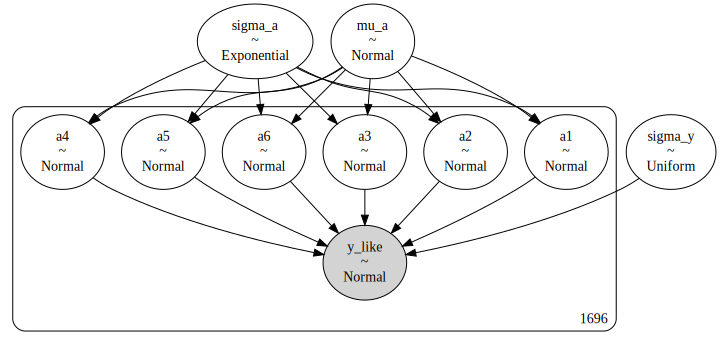

In [141]:
with Model() as varying_intercept:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)

    # Random intercepts
    a1 = pm.Normal('a1', mu=mu_a, sigma=sigma_a, shape = len(train_speed))
    a2 = pm.Normal('a2', mu=mu_a, sigma=sigma_a, shape = len(train_speed))
    a3 = pm.Normal('a3', mu=mu_a, sigma=sigma_a, shape = len(train_speed))
    a4 = pm.Normal('a4', mu=mu_a, sigma=sigma_a, shape = len(train_speed))
    a5 = pm.Normal('a5', mu=mu_a, sigma=sigma_a, shape = len(train_speed))
    a6 = pm.Normal('a6', mu=mu_a, sigma=sigma_a, shape = len(train_speed))

    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a1[train_speed2['dummy_tackle']] + a2[train_speed2['end_speed_perc'].astype(int)] + a3[train_speed2['end_height']] + a4[train_speed2['end_weight']] + a5[train_speed2['obvious_pass']] + a6[train_speed2['quarter']] 

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=train_speed2.iloc[:,2])

pm.model_to_graphviz(varying_intercept)

In [143]:
with varying_intercept:
    varying_intercept_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 4, tune=500)
    varying_intercept_trace.extend(pm.sample_prior_predictive())
    varying_intercept_trace.extend(pm.sample_posterior_predictive(varying_intercept_trace))
az.summary(varying_intercept_trace, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a1, a2, a3, a4, a5, a6, sigma_y]


/Users/connornickol/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/connornickol/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/connornickol/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/connornickol/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 781 seconds.
Sampling: [a1, a2, a3, a4, a5, a6, mu_a, sigma_a, sigma_y, y_like]
Sampling: [y_like]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,0.20,0.05,0.10,0.29,0.02,0.01,7.54,32.54,1.53
a1[0],0.29,0.09,0.13,0.45,0.02,0.01,23.89,107.99,1.11
a1[1],0.16,0.10,-0.05,0.34,0.02,0.01,27.60,104.21,1.09
a1[2],0.16,0.12,-0.08,0.39,0.02,0.01,47.66,564.80,1.05
a1[3],0.46,0.11,0.28,0.69,0.02,0.01,33.13,109.18,1.08
...,...,...,...,...,...,...,...,...,...
a6[1693],0.20,0.18,-0.18,0.51,0.02,0.01,92.87,119.35,1.03
a6[1694],0.20,0.19,-0.14,0.56,0.01,0.01,295.54,368.50,1.02
a6[1695],0.19,0.19,-0.20,0.51,0.01,0.01,179.81,435.83,1.03
sigma_a,0.17,0.04,0.12,0.26,0.02,0.01,6.23,23.87,1.72


KeyboardInterrupt: 

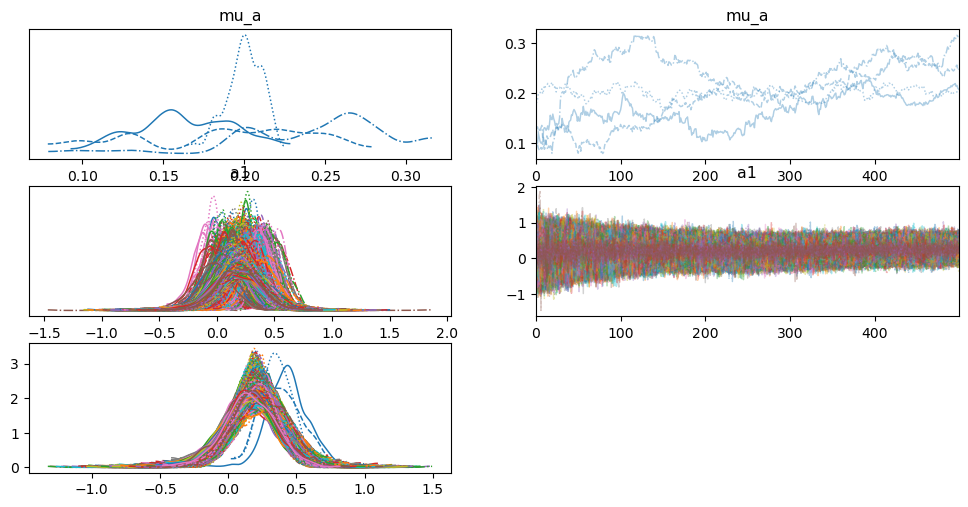

In [144]:
with varying_intercept:
    pm.plot_trace(varying_intercept_trace)